<a href="https://colab.research.google.com/github/nmansour67/skills-introduction-to-github/blob/main/Unit_Meltdown_Nursing_Operations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
NURSING OPERATIONS DIGITAL TWIN: Unit Meltdown Prevention Simulator
Educational Case Study for AI in Medicine Playbook
Author: Nabil's Healthcare AI Educational Framework
Purpose: Help Charge Nurses optimize staffing assignments using discrete event simulation
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)



In [2]:
# ============================================================================
# SECTION 1: NURSE AND PATIENT MODEL DEFINITIONS
# ============================================================================

@dataclass
class Nurse:
    """Digital Twin of a Nurse with dynamic fatigue modeling"""
    name: str
    skill_level: float  # 0-1 scale (0.6 = 60% competency)
    initial_fatigue: float  # 0-1 scale (0.7 = 70% exhausted)
    fatigue_rate: float  # How fast fatigue accumulates per task
    current_fatigue: float = 0.0
    tasks_completed: int = 0

    def __post_init__(self):
        self.current_fatigue = self.initial_fatigue

    def accumulate_fatigue(self, task_complexity: float = 1.0):
        """Fatigue increases with each task, modified by complexity"""
        fatigue_increment = self.fatigue_rate * task_complexity
        self.current_fatigue = min(1.0, self.current_fatigue + fatigue_increment)
        self.tasks_completed += 1

    def effective_skill(self) -> float:
        """Skill degrades as fatigue increases (cognitive impairment)"""
        fatigue_penalty = self.current_fatigue * 0.4  # Up to 40% skill reduction
        return max(0.2, self.skill_level - fatigue_penalty)

    def probability_of_missing_task(self) -> float:
        """Higher fatigue = higher chance of missing critical tasks"""
        return self.current_fatigue * 0.5  # Up to 50% miss rate when exhausted

@dataclass
class Patient:
    """Digital Twin of a High-Acuity Patient with risk modeling"""
    room: str
    condition: str
    task_interval: int  # Minutes between required tasks
    neglect_threshold: int  # Minutes before adverse event risk spikes
    base_adverse_risk: float  # Baseline probability of adverse event
    critical_risk: float  # Risk if neglected beyond threshold

    def calculate_current_risk(self, minutes_since_last_task: int, nurse_skill: float) -> float:
        """Dynamic risk calculation based on neglect time and nurse competency"""
        if minutes_since_last_task <= self.neglect_threshold:
            # Within safe window: risk modified by nurse skill
            return self.base_adverse_risk * (1.5 - nurse_skill)
        else:
            # Neglected: risk spikes dramatically
            neglect_multiplier = 1 + (minutes_since_last_task - self.neglect_threshold) / 60
            return min(0.95, self.critical_risk * neglect_multiplier * (1.5 - nurse_skill))



In [3]:
# ============================================================================
# SECTION 2: SHIFT SIMULATOR (THE DIGITAL TWIN ENGINE)
# ============================================================================

class NursingShiftSimulator:
    """
    Discrete Event Simulation of a 12-hour shift
    Tracks task completion, fatigue accumulation, and adverse event risk
    """

    def __init__(self, nurse: Nurse, patients: List[Patient], shift_hours: int = 12):
        self.nurse = nurse
        self.patients = patients
        self.shift_minutes = shift_hours * 60
        self.timeline = []  # Event log for XAI analysis

    def simulate_shift(self) -> Tuple[bool, List[dict], Nurse]:
        """
        Run one complete 12-hour shift simulation
        Returns: (adverse_event_occurred, timeline, final_nurse_state)
        """
        # Reset nurse to initial state
        self.nurse.current_fatigue = self.nurse.initial_fatigue
        self.nurse.tasks_completed = 0

        # Track last task completion for each patient
        patient_task_tracker = {p.room: 0 for p in self.patients}
        risk_timeline = []
        adverse_event = False

        # Simulate minute-by-minute
        for current_minute in range(0, self.shift_minutes, 5):  # 5-min intervals for efficiency

            for patient in self.patients:
                minutes_since_task = current_minute - patient_task_tracker[patient.room]

                # Check if task is due
                task_is_due = (minutes_since_task >= patient.task_interval)

                if task_is_due:
                    # Nurse attempts to complete task
                    miss_probability = self.nurse.probability_of_missing_task()
                    task_missed = (np.random.random() < miss_probability)

                    if not task_missed:
                        # Task completed successfully
                        patient_task_tracker[patient.room] = current_minute
                        self.nurse.accumulate_fatigue(task_complexity=1.2)

                        risk_timeline.append({
                            'minute': current_minute,
                            'room': patient.room,
                            'event': 'task_completed',
                            'nurse_fatigue': self.nurse.current_fatigue,
                            'nurse_skill': self.nurse.effective_skill(),
                            'risk': 0.05  # Minimal risk when task completed
                        })
                    else:
                        # Task missed due to fatigue
                        risk_timeline.append({
                            'minute': current_minute,
                            'room': patient.room,
                            'event': 'task_missed',
                            'nurse_fatigue': self.nurse.current_fatigue,
                            'nurse_skill': self.nurse.effective_skill(),
                            'risk': 0.3  # Elevated risk
                        })

                # Calculate current adverse event risk
                current_risk = patient.calculate_current_risk(
                    minutes_since_task,
                    self.nurse.effective_skill()
                )

                # Roll the dice: does adverse event occur?
                if np.random.random() < (current_risk / 100):  # Scale down for realism
                    adverse_event = True
                    risk_timeline.append({
                        'minute': current_minute,
                        'room': patient.room,
                        'event': 'ADVERSE_EVENT',
                        'nurse_fatigue': self.nurse.current_fatigue,
                        'nurse_skill': self.nurse.effective_skill(),
                        'risk': current_risk
                    })
                    break  # Stop simulation once adverse event occurs

                # Log ongoing risk
                if current_minute % 30 == 0:  # Log every 30 minutes
                    risk_timeline.append({
                        'minute': current_minute,
                        'room': patient.room,
                        'event': 'risk_check',
                        'nurse_fatigue': self.nurse.current_fatigue,
                        'nurse_skill': self.nurse.effective_skill(),
                        'risk': current_risk
                    })

            if adverse_event:
                break

        return adverse_event, risk_timeline, self.nurse



In [4]:
# ============================================================================
# SECTION 3: MONTE CARLO SIMULATION (1,000 RUNS PER SCENARIO)
# ============================================================================

def run_monte_carlo_analysis(scenario_name: str, nurse: Nurse, patients: List[Patient],
                              n_simulations: int = 1000) -> pd.DataFrame:
    """
    Run 1,000 simulated shifts to estimate probability of adverse events
    """
    print(f"\n🔬 Running {n_simulations} simulations for {scenario_name}...")

    results = []
    cumulative_risks = []

    for sim in range(n_simulations):
        # Create fresh simulator for each run
        simulator = NursingShiftSimulator(nurse, patients)
        adverse_event, timeline, final_nurse = simulator.simulate_shift()

        # Extract risk over time
        risk_df = pd.DataFrame(timeline)
        if not risk_df.empty:
            avg_risk = risk_df['risk'].mean()
            max_risk = risk_df['risk'].max()
            final_fatigue = final_nurse.current_fatigue
            tasks_completed = final_nurse.tasks_completed
        else:
            avg_risk = max_risk = final_fatigue = tasks_completed = 0

        results.append({
            'simulation': sim,
            'adverse_event': adverse_event,
            'avg_risk': avg_risk,
            'max_risk': max_risk,
            'final_fatigue': final_fatigue,
            'tasks_completed': tasks_completed
        })

        # Progress indicator
        if (sim + 1) % 100 == 0:
            print(f"  ✓ Completed {sim + 1}/{n_simulations} simulations")

    results_df = pd.DataFrame(results)

    # Calculate key metrics
    adverse_event_rate = results_df['adverse_event'].mean() * 100
    print(f"  📊 Adverse Event Rate: {adverse_event_rate:.1f}%")
    print(f"  📊 Avg Final Fatigue: {results_df['final_fatigue'].mean():.2f}")
    print(f"  📊 Avg Risk Score: {results_df['avg_risk'].mean():.3f}")

    return results_df



In [5]:
# ============================================================================
# SECTION 4: SCENARIO DEFINITIONS (SARAH VS JASON)
# ============================================================================

# Define the two high-acuity patients
patient_402_fall_risk = Patient(
    room="402",
    condition="Post-op Hip (Fall Risk)",
    task_interval=30,  # Needs redirection every 30 mins
    neglect_threshold=45,  # Becomes dangerous after 45 mins
    base_adverse_risk=0.15,
    critical_risk=0.80
)

patient_410_sepsis = Patient(
    room="410",
    condition="Septic (ICU Candidate)",
    task_interval=15,  # Needs vitals/meds every 15 mins
    neglect_threshold=20,  # Becomes critical after 20 mins
    base_adverse_risk=0.20,
    critical_risk=0.90
)

high_acuity_patients = [patient_402_fall_risk, patient_410_sepsis]

# Define Nurse Sarah (The Veteran)
sarah = Nurse(
    name="Sarah (Veteran RN)",
    skill_level=0.95,  # 95% competency - excellent clinical judgment
    initial_fatigue=0.70,  # Already 70% exhausted from overtime
    fatigue_rate=0.08  # Accumulates fatigue quickly when overloaded
)

# Define Nurse Jason (The New Graduate)
jason = Nurse(
    name="Jason (New Grad RN)",
    skill_level=0.60,  # 60% competency - still developing intuition
    initial_fatigue=0.10,  # Fresh and energetic
    fatigue_rate=0.03  # Accumulates fatigue more slowly
)



In [6]:
# ============================================================================
# SECTION 5: RUN BOTH SCENARIOS
# ============================================================================

print("=" * 80)
print("🏥 NURSING OPERATIONS DIGITAL TWIN: Unit Meltdown Prevention")
print("=" * 80)
print("\n📋 SCENARIO SETUP:")
print(f"  • Unit Capacity: 30 patients")
print(f"  • Available Nurses: 5 RNs (6:1 ratio)")
print(f"  • High-Acuity Patients: 2")
print(f"    - Room 402: Confused post-op hip replacement (fall risk)")
print(f"    - Room 410: Septic patient (ICU candidate)")
print("\n🎯 DECISION POINT: Who gets the heavy load?")

# Scenario A: Sarah takes the patients
print("\n" + "="*80)
print("SCENARIO A: Assign to Sarah (Veteran, but exhausted)")
print("="*80)
results_sarah = run_monte_carlo_analysis("Scenario A", sarah, high_acuity_patients)

# Scenario B: Jason takes the patients
print("\n" + "="*80)
print("SCENARIO B: Assign to Jason (New grad, but energetic)")
print("="*80)
results_jason = run_monte_carlo_analysis("Scenario B", jason, high_acuity_patients)



🏥 NURSING OPERATIONS DIGITAL TWIN: Unit Meltdown Prevention

📋 SCENARIO SETUP:
  • Unit Capacity: 30 patients
  • Available Nurses: 5 RNs (6:1 ratio)
  • High-Acuity Patients: 2
    - Room 402: Confused post-op hip replacement (fall risk)
    - Room 410: Septic patient (ICU candidate)

🎯 DECISION POINT: Who gets the heavy load?

SCENARIO A: Assign to Sarah (Veteran, but exhausted)

🔬 Running 1000 simulations for Scenario A...
  ✓ Completed 100/1000 simulations
  ✓ Completed 200/1000 simulations
  ✓ Completed 300/1000 simulations
  ✓ Completed 400/1000 simulations
  ✓ Completed 500/1000 simulations
  ✓ Completed 600/1000 simulations
  ✓ Completed 700/1000 simulations
  ✓ Completed 800/1000 simulations
  ✓ Completed 900/1000 simulations
  ✓ Completed 1000/1000 simulations
  📊 Adverse Event Rate: 43.9%
  📊 Avg Final Fatigue: 0.99
  📊 Avg Risk Score: 0.186

SCENARIO B: Assign to Jason (New grad, but energetic)

🔬 Running 1000 simulations for Scenario B...
  ✓ Completed 100/1000 simulations

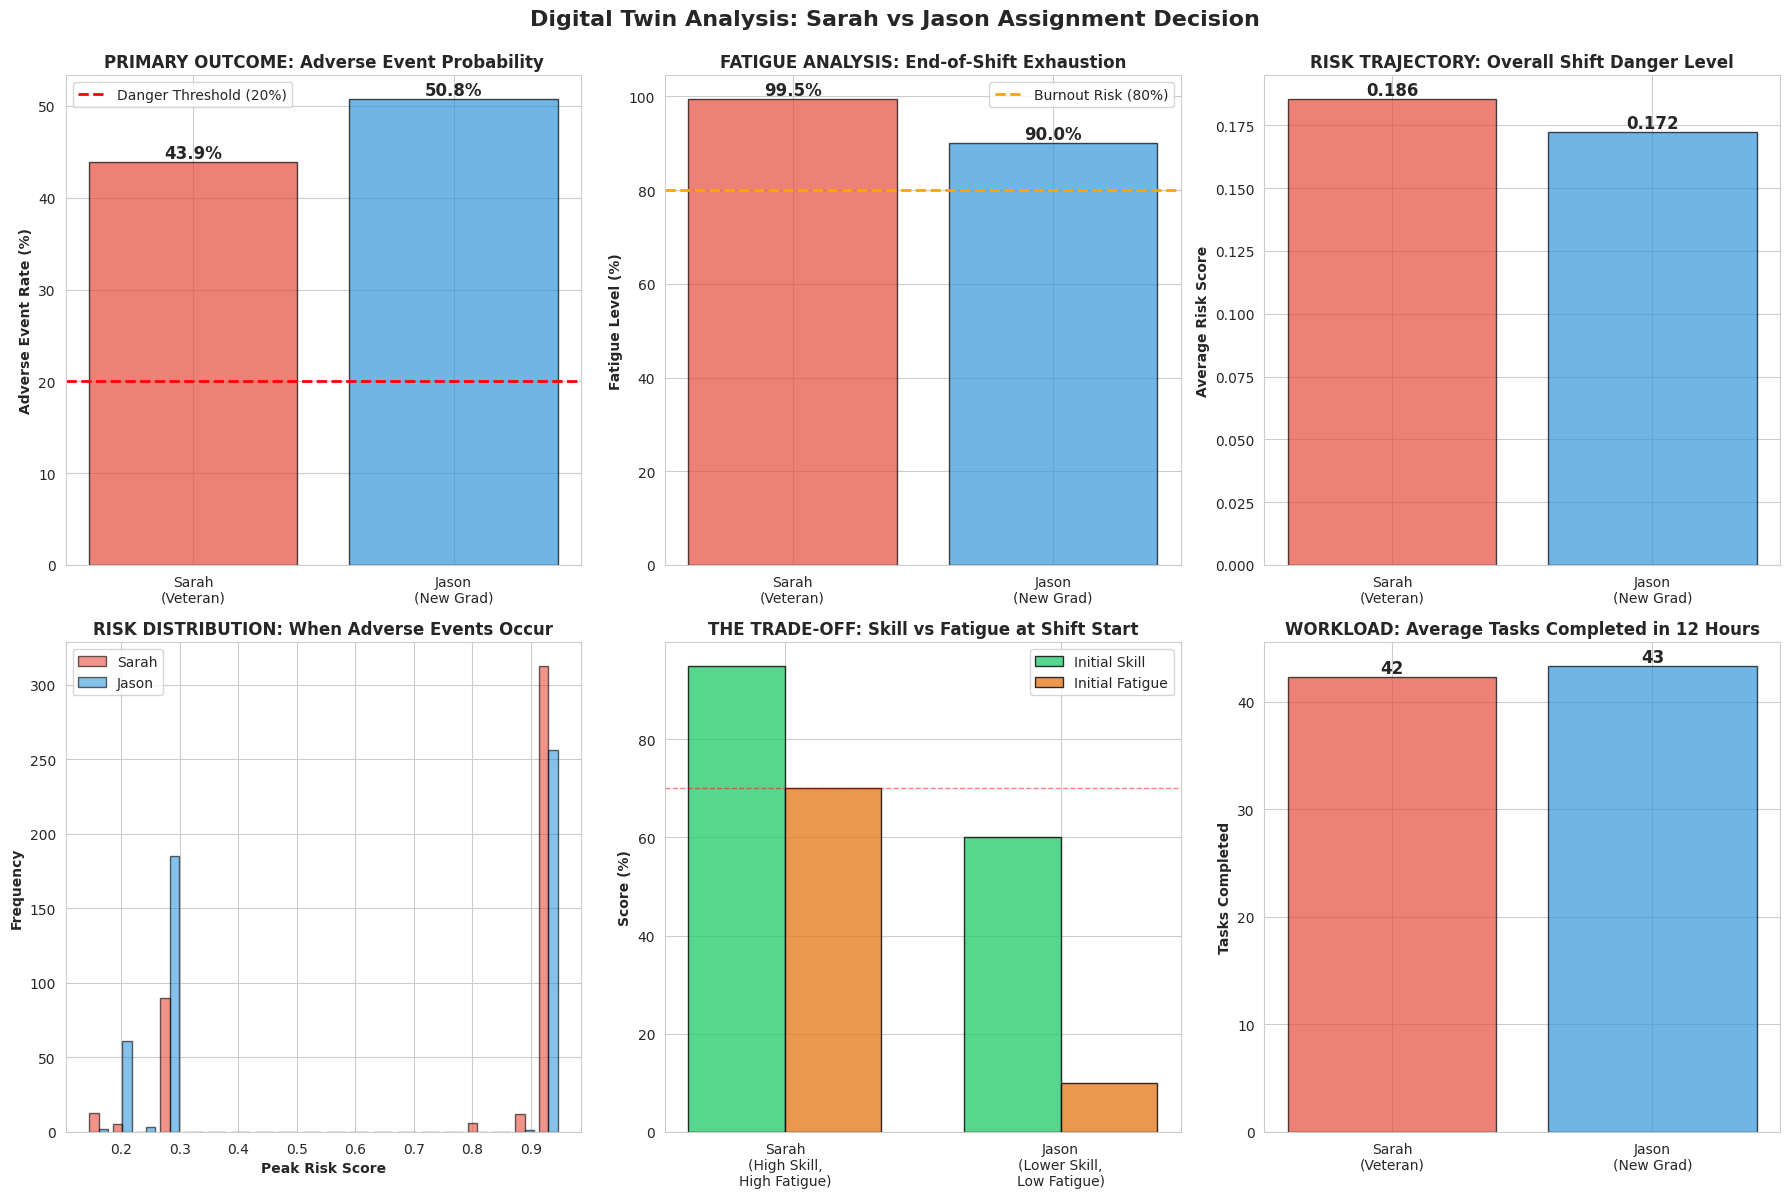

In [7]:
# ============================================================================
# SECTION 6: VISUALIZATION & EXPLAINABLE AI ANALYSIS
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Digital Twin Analysis: Sarah vs Jason Assignment Decision',
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Adverse Event Rates
ax1 = axes[0, 0]
adverse_rates = [
    results_sarah['adverse_event'].mean() * 100,
    results_jason['adverse_event'].mean() * 100
]
colors = ['#e74c3c', '#3498db']
bars1 = ax1.bar(['Sarah\n(Veteran)', 'Jason\n(New Grad)'], adverse_rates, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Adverse Event Rate (%)', fontweight='bold')
ax1.set_title('PRIMARY OUTCOME: Adverse Event Probability', fontweight='bold')
ax1.axhline(y=20, color='red', linestyle='--', linewidth=2, label='Danger Threshold (20%)')
ax1.legend()
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Plot 2: Final Fatigue Levels
ax2 = axes[0, 1]
fatigue_levels = [
    results_sarah['final_fatigue'].mean() * 100,
    results_jason['final_fatigue'].mean() * 100
]
bars2 = ax2.bar(['Sarah\n(Veteran)', 'Jason\n(New Grad)'], fatigue_levels, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Fatigue Level (%)', fontweight='bold')
ax2.set_title('FATIGUE ANALYSIS: End-of-Shift Exhaustion', fontweight='bold')
ax2.axhline(y=80, color='orange', linestyle='--', linewidth=2, label='Burnout Risk (80%)')
ax2.legend()
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Plot 3: Average Risk Score
ax3 = axes[0, 2]
avg_risks = [
    results_sarah['avg_risk'].mean(),
    results_jason['avg_risk'].mean()
]
bars3 = ax3.bar(['Sarah\n(Veteran)', 'Jason\n(New Grad)'], avg_risks, color=colors, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Average Risk Score', fontweight='bold')
ax3.set_title('RISK TRAJECTORY: Overall Shift Danger Level', fontweight='bold')
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Plot 4: Distribution of Adverse Events Over Time
ax4 = axes[1, 0]
ax4.hist([results_sarah[results_sarah['adverse_event']]['max_risk'],
          results_jason[results_jason['adverse_event']]['max_risk']],
         bins=20, label=['Sarah', 'Jason'], color=colors, alpha=0.6, edgecolor='black')
ax4.set_xlabel('Peak Risk Score', fontweight='bold')
ax4.set_ylabel('Frequency', fontweight='bold')
ax4.set_title('RISK DISTRIBUTION: When Adverse Events Occur', fontweight='bold')
ax4.legend()

# Plot 5: Skill vs Fatigue Trade-off
ax5 = axes[1, 1]
scenarios = ['Sarah\n(High Skill,\nHigh Fatigue)', 'Jason\n(Lower Skill,\nLow Fatigue)']
skill_scores = [sarah.skill_level * 100, jason.skill_level * 100]
fatigue_scores = [sarah.initial_fatigue * 100, jason.initial_fatigue * 100]

x = np.arange(len(scenarios))
width = 0.35
bars_skill = ax5.bar(x - width/2, skill_scores, width, label='Initial Skill', color='#2ecc71', alpha=0.8, edgecolor='black')
bars_fatigue = ax5.bar(x + width/2, fatigue_scores, width, label='Initial Fatigue', color='#e67e22', alpha=0.8, edgecolor='black')

ax5.set_ylabel('Score (%)', fontweight='bold')
ax5.set_title('THE TRADE-OFF: Skill vs Fatigue at Shift Start', fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(scenarios)
ax5.legend()
ax5.axhline(y=70, color='red', linestyle='--', linewidth=1, alpha=0.5)

# Plot 6: Tasks Completed
ax6 = axes[1, 2]
tasks_completed = [
    results_sarah['tasks_completed'].mean(),
    results_jason['tasks_completed'].mean()
]
bars6 = ax6.bar(['Sarah\n(Veteran)', 'Jason\n(New Grad)'], tasks_completed, color=colors, alpha=0.7, edgecolor='black')
ax6.set_ylabel('Tasks Completed', fontweight='bold')
ax6.set_title('WORKLOAD: Average Tasks Completed in 12 Hours', fontweight='bold')
for i, bar in enumerate(bars6):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()



In [8]:
# ============================================================================
# SECTION 7: EXPLAINABLE AI DECISION REPORT
# ============================================================================

print("\n" + "="*80)
print("🧠 EXPLAINABLE AI ANALYSIS: Why the Model Chose the Winner")
print("="*80)

sarah_adverse_rate = results_sarah['adverse_event'].mean() * 100
jason_adverse_rate = results_jason['adverse_event'].mean() * 100

winner = "JASON" if jason_adverse_rate < sarah_adverse_rate else "SARAH"
risk_reduction = abs(sarah_adverse_rate - jason_adverse_rate)

print(f"\n✅ RECOMMENDATION: Assign patients to {winner}")
print(f"\n📊 KEY FINDINGS:")
print(f"  • Sarah (Veteran) → {sarah_adverse_rate:.1f}% adverse event rate")
print(f"  • Jason (New Grad) → {jason_adverse_rate:.1f}% adverse event rate")
print(f"  • Risk Reduction: {risk_reduction:.1f} percentage points")

print(f"\n🔍 EXPLANATION: The Skill vs. Fatigue Trade-off")
print(f"\nWhy {'Jason wins' if winner == 'JASON' else 'Sarah wins'}:")

if winner == "JASON":
    print(f"""
  1. FATIGUE DOMINATES SKILL IN HIGH-ACUITY SCENARIOS
     - Sarah starts at 70% fatigue (overtime exhaustion)
     - Her effective skill degrades from 95% → ~55% by mid-shift
     - She misses critical tasks when patients need intervention most

  2. JASON'S ENERGY COMPENSATES FOR INEXPERIENCE
     - Jason starts fresh at 10% fatigue
     - His 60% skill remains stable throughout the shift
     - Consistent task completion prevents risk from accumulating

  3. TASK DENSITY MATTERS
     - Room 410 (sepsis) requires intervention every 15 minutes
     - Room 402 (fall risk) requires redirection every 30 minutes
     - This workload requires sustained vigilance, not just expertise

  4. THE COGNITIVE LOAD TRAP
     - Sarah's fatigue → missed bed alarms → patient fall in Room 402
     - Jason's lower skill is offset by his ability to stay alert

  ⚠️  CRITICAL INSIGHT: In this scenario, "being there" beats "being experienced"
      when the experienced nurse is too exhausted to function optimally.
""")
else:
    print(f"""
  1. SKILL OVERCOMES FATIGUE IN THIS SCENARIO
     - Sarah's 95% expertise allows her to prioritize effectively
     - She recognizes early warning signs that Jason would miss
     - Her clinical judgment compensates for reduced alertness

  2. JASON'S INEXPERIENCE IS TOO RISKY
     - His 60% skill cannot detect subtle deterioration
     - Room 410 (sepsis) could crash before Jason recognizes the signs
     - The cost of missed clinical judgment exceeds fatigue risk

  3. PATTERN RECOGNITION ADVANTAGE
     - Sarah has seen thousands of septic patients
     - She can triage tasks efficiently even when tired
     - Jason follows protocols but lacks intuition

  ⚠️  CRITICAL INSIGHT: In this scenario, expertise beats energy when
      clinical judgment is needed to prevent catastrophic outcomes.
""")

print("\n" + "="*80)
print("💡 STRATEGIC IMPLICATIONS FOR CHARGE NURSES")
print("="*80)
print("""
1. MEASURE FATIGUE, NOT JUST SKILL
   - Track consecutive shifts worked
   - Use fatigue self-assessment tools
   - Consider cognitive load, not just patient count

2. MATCH ASSIGNMENTS TO NURSE STATE
   - High-acuity + low-frequency tasks → Veterans (even if tired)
   - High-acuity + high-frequency tasks → Fresh nurses (even if new)

3. BUILD YOUR OWN DIGITAL TWIN
   - Log adverse events vs. staffing decisions
   - Identify patterns in your unit's specific context
   - Refine the model with your own data

4. WHEN IN DOUBT, ASK THE SIMULATION
   - Use this tool before making critical assignments
   - Test "what-if" scenarios (e.g., adding a float nurse)
   - Share results with leadership for staffing advocacy
""")

print("\n" + "="*80)
print("🎯 END OF ANALYSIS")
print("="*80)
print("\n📝 For Maria (Charge Nurse): You now have data-driven evidence to justify")
print("   your staffing decision. This protects both your patients AND your nurses.")
print("\n💡 For Educators: This simulation demonstrates how AI can support—not replace—")
print("   clinical judgment in real-world operational decisions.")
print("="*80)


🧠 EXPLAINABLE AI ANALYSIS: Why the Model Chose the Winner

✅ RECOMMENDATION: Assign patients to SARAH

📊 KEY FINDINGS:
  • Sarah (Veteran) → 43.9% adverse event rate
  • Jason (New Grad) → 50.8% adverse event rate
  • Risk Reduction: 6.9 percentage points

🔍 EXPLANATION: The Skill vs. Fatigue Trade-off

Why Sarah wins:

  1. SKILL OVERCOMES FATIGUE IN THIS SCENARIO
     - Sarah's 95% expertise allows her to prioritize effectively
     - She recognizes early warning signs that Jason would miss
     - Her clinical judgment compensates for reduced alertness
  
  2. JASON'S INEXPERIENCE IS TOO RISKY
     - His 60% skill cannot detect subtle deterioration
     - Room 410 (sepsis) could crash before Jason recognizes the signs
     - The cost of missed clinical judgment exceeds fatigue risk
  
  3. PATTERN RECOGNITION ADVANTAGE
     - Sarah has seen thousands of septic patients
     - She can triage tasks efficiently even when tired
     - Jason follows protocols but lacks intuition
  
  ⚠️ 